# Lab One: Visualization and Data Preprocessing

## Business Understanding

DonorsChoose.org is a crowd-funding website designed for teachers, by teachers. The current state of public school funding often leaves teachers to pay for supplies for projects that are beyond their available budget. In 2000, public school teachers in the Bronx launched DonorsChoose, and it has since spread to be available to all public schools in the United States. 

Teachers who work full-time in a public school in the US are eligible to submit a project. DonorsChoose then screens and posts the project to the site in a few days. Projects can remain on the site for up to four months. Donors contribute funds toward the projects they are interested in, and when the project is fully funded, DonorsChoose purchases the materials and sends it to the teacher. 

The dataset that we are working with was collected and shared on Kaggle by DonorsChoose.org. Because each project is screened before being posted, and the number of requests is expected to be large in coming years, the organization wants to find ways to pre-screen project requests. In doing so, the goal is to be able to auto-approve some requests, which will allow volunteers to focus their time on more complicated project requests. With this data, we will be working to determine which features are most predictive of approval. 

This is a classification problem, looking to predict whether a project submission is approved or not. To evaluate our predictive model effectiveness, we'll look at the are under the ROC. Because the purpose of this model is to shift work/attention to project submissions that need additional assistnace, a relatively low improvement over random would be considered useful. 10-fold cross-validation

## Data Meaning

The dataset is broken into two files: the project information, contained in the test and train files, and the resources data, contained in the resources file. These two files can be joined based on ID to get the resources attributed to the project overal information. 

The project information contains the following: 

| attribute | description | data type | scale/values |
| :-------- | :---------- | :-------: | :----------: |
| id | unique id for each project request | | unique values |
| teacher id | unique id for each teacher making a request | | repeated values when teacher submits multiple projects |
| teacher_prefix | title abbreviation the teacher uses | char | 'Ms.', 'Mrs.', 'Mr.', 'Teacher', 'Dr.' |
| school_state | two letter code of state where school is located | char(2) | 51 values: 50 states + DC |
| project_submitted_datetime | timestamp of application submission | datetime | The earliest submission was 2016-04-27 00:03:38.<br>The latest submission was 2017-04-30 23:50:43. |
| project_grade_category | indicates the school level of the classroom project | categorical, single-selected | 'Grades PreK-2'<br>'Grades 3-5'<br>'Grades 6-8'<br>'Grades 9-12'|
| project_subject_categories | high-level subject of the project | categorical, multi-selected | 'Literacy & Language'<br>'Math & Science'<br>'Applied Learning'<br>'Health & Sports'<br>'Special Needs'<br>'History & Civics'<br>'Music & The Arts'<br>'Warmth, Care & Hunger' |
| project_subject_subcategories | lower-level subject category | categorical, multi-selected | 29 subcategories |
| project title | title given to the project | text | length ranges from 4 to 141 characters |
| project_resource_summary | text summary of the resources that are being requested | text | length ranges from 25 to 908 characters |
| teacher_number_of_previously_posted_projects | shows how many projects the teacher has previously posted | numeric | 0-451 |
| project_is_approved | whether the project was approved or not by DonorsChoose | binary | '0'=rejected, '1'=accepted |

In addition to the featuers above, each submission contains 2 or 4 essay responses. For projects submitted before May 17, 2016, four essay questions were asked:
* project_essay_1: "Introduce us to your classroom"
* project_essay_2: "Tell us more about your students"
* project_essay_3: "Describe how your students will use the materials you're requesting"
* project_essay_4: "Close by sharing why your project will make a difference"

After May 17, 2016, only two essay questions were asked: 
* project_essay_1: "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."
* project_essay_2: "About your project: How will these materials make a difference in your students' learning and improve their school lives?"

In our analysis, we will need to account for these differences by submission date to ensure that we are comparing comparable questions. 

The Resources contains the following:

| attribute | description | data type | scale/values |
| :-------- | :---------- | :-------: | ------------ |
| id | unique id for each project request | varchar | foreign key to the project information files |
| description | description of the resource being requested | text | |
| quantity | the number of this resource being requested | numeric | 1 - 800 | 
| price | the price per unit of the resources | numeric | 0 - 9999.00 |

In [5]:
##SOURCE: https://github.com/kaggle/kaggle-api
#Run the following command to access the Kaggle API using the command line: pip install kaggle
#go to the 'Account' tab of your user profile (https://www.kaggle.com/<username>/account) and select 'Create API Token'
#This will trigger the download of kaggle.json, a file containing your API credentials. 
#Place this file in the location ~/.kaggle/kaggle.json 
    #(on Windows in the location C:\Users\<Windows-username>\.kaggle\kaggle.json).
#Run the following using the command line: kaggle competitions download -c donorschoose-application-screening
    #if you get an access denied warning you need to go to https://www.kaggle.com/c/donorschoose-application-screening/data
        #then click download for any zip file and click on 'accept rules' popup
            #you can now run the api download
#this will save to C:\Users\<Windows-username>\.kaggle\competitions\donorschoose-application-screening
#upload the csvs to your Jupyter 'data' file

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
df_train = pd.read_csv('train.csv')
df_train.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,16,0
4,p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,My students need a water filtration system for...,42,1


In [7]:
df_resources = pd.read_csv('resources.csv')
df_resources.head()

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95


In [8]:
#https://www.kaggle.com/codename007/a-very-extensive-end-to-end-project-donorschoose
## Merging with train and test data ##
train_resource = pd.merge(df_train, df_resources, on="id", how='left')

In [9]:
print("Size of training data : ",df_train.shape)
print("Size of resource data : ",df_resources.shape)
print("Size of train_resource data : ",train_resource.shape)

Size of training data :  (182080, 16)
Size of resource data :  (1541272, 4)
Size of train_resource data :  (1081830, 19)


# Data Quality

We start our examination of the data's quality by looking at the presence of missing values.

In [10]:
print('The number of missing values in the main data frame: ', np.sum(df_train.isnull()))

The number of missing values in the main data frame:  id                                                   0
teacher_id                                           0
teacher_prefix                                       4
school_state                                         0
project_submitted_datetime                           0
project_grade_category                               0
project_subject_categories                           0
project_subject_subcategories                        0
project_title                                        0
project_essay_1                                      0
project_essay_2                                      0
project_essay_3                                 175706
project_essay_4                                 175706
project_resource_summary                             0
teacher_number_of_previously_posted_projects         0
project_is_approved                                  0
dtype: int64


We see that a vast majority of the columns do not have missing values. There are 4 missing data points in the teacher_prefix column. This houses data on the teacher's preferred prefix. We would like to look at whether or not there are other problems with these entries, for the sake of completeness. A majority of our rows are missing project essays 3 and 4; that will be discussed after the missing teacher prefixes are examined. 

In [11]:
df_train[df_train.teacher_prefix.isnull()]

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
17809,p180947,834f75f1b5e24bd10abe9c3dbf7ba12f,NaN,CA,2016-11-04 00:15:45,Grades 3-5,"Literacy & Language, Math & Science","Literature & Writing, Mathematics",1:7 Increasing Tech to Decrease Achievement Gaps,The children at Anna Yates Elementary school a...,My goal is to bring in 1 laptop for every 7 st...,NaN,NaN,My students need a classroom laptop that is ju...,1,1
22174,p002730,339bd5a9e445d68a74d65b99cd325397,NaN,SC,2016-05-09 09:38:40,Grades 9-12,Literacy & Language,Literature & Writing,iPads for STEM Stations,"Within the next 20 years, every job will invol...",The students in our school come from a wide va...,Students will use the iPad station for individ...,Your generosity will allow my students to work...,My students need 5 iPads for STEM stations.,0,1
127966,p153408,339bd5a9e445d68a74d65b99cd325397,NaN,SC,2016-05-10 15:18:23,Grades 9-12,Literacy & Language,Literature & Writing,iPad for STEM and Literacy Station,"Within the next 20 years, every job will invol...",The students in our school come from a wide va...,Students will use the iPad at the iPad station...,Your generosity will allow my students to work...,My students need 5 iPads with protection plans...,1,1
158692,p197901,e4be6aaaa887d4202df2b647fbfc82bb,NaN,PA,2016-06-03 10:15:05,Grades 3-5,"Literacy & Language, Math & Science","Literacy, Mathematics",Document Camera,Students at Robertsdale Elementary live in a l...,This SMART Document Camera will improve my stu...,NaN,NaN,My students need a Smart Document Camera to en...,0,1


As we can see, these entries are otherwise complete. The fact that it is missing is not concerning, it is likely that the teacher did not wish to identify their gender when completing the application, or they simply forgot to input a value. These missing values are therefore not a large concern for our data analysis, and these rows will be left untouched.

There are also roughly 176,000 rows that do not have the third and fourth project essays. This is because on May 17, 2016, DonorsChoose.org reduced the number of required essays from four to two. Therefore, it is realistic to believe that entries with all four essays were submitted before this date, and entries with only two essays were submitted after this date. The missing data is therefore not a call for concern. 

We also would like to check for missing values in the resource request dataset.

In [12]:
print('The number of missing values in the resource request dataset: ', np.sum(train_resource.isnull()))

The number of missing values in the resource request dataset:  id                                                    0
teacher_id                                            0
teacher_prefix                                       11
school_state                                          0
project_submitted_datetime                            0
project_grade_category                                0
project_subject_categories                            0
project_subject_subcategories                         0
project_title                                         0
project_essay_1                                       0
project_essay_2                                       0
project_essay_3                                 1043673
project_essay_4                                 1043673
project_resource_summary                              0
teacher_number_of_previously_posted_projects          0
project_is_approved                                   0
description                              

Once again, we see that some requests for items are missing teacher prefixes and the third and fourth project essays. As discuassed before, the fact that these are missing are not a big concern to us.

What might be concerning is the missing discriptions.

In [13]:
train_resource[train_resource.description.isnull()].head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,description,quantity,price
4024,p024765,0c0df47224ad114b5c41cb801f0852e1,Mrs.,AR,2016-10-11 21:08:06,Grades 6-8,Applied Learning,"Character Education, Extracurricular",Crafting Cultural Acceptance,Our school serves a large rural area with over...,These crafting supplies will help bring to lif...,NaN,NaN,My students need craft supplies to bring to li...,0,0,NaN,1,9.95
23171,p154785,6e0e96a0225526789ae750eff06491c9,Mrs.,AR,2016-11-17 17:26:08,Grades PreK-2,Math & Science,"Applied Sciences, Mathematics",Hands on Learning Activities,My classroom family includes 19 excited and dr...,With these materials I will be able to create ...,NaN,NaN,My students need more hands on materials to pr...,0,1,NaN,1,9.95
25584,p180414,b62e6f4c3ffa9941328b071dfb7c3207,Mrs.,GA,2016-10-26 19:30:22,Grades 3-5,"History & Civics, Music & The Arts","History & Geography, Visual Arts",New Media Mania,Our students appreciate a smile and encouragem...,We are asking for some new materials for our A...,NaN,NaN,My students need some to experiment with excit...,8,1,NaN,1,9.95
26445,p233362,81b426f793c5142f972ecaf89bbc168b,Mrs.,TX,2016-12-05 16:36:25,Grades 3-5,Music & The Arts,Visual Arts,Art Supplies,"My students are full of life, and are ready to...","I teach 1st-6th grade, and we are in desperate...",NaN,NaN,My students need are in desperate need of exci...,0,1,NaN,1,9.95
37565,p121762,0f94cea7872eaf2e005036314ce03240,Mrs.,NY,2016-11-01 20:34:41,Grades 6-8,Music & The Arts,"Performing Arts, Visual Arts",Craft Club Moves to Queens,"As I walk into the lunch room, I hear students...",Our after school craft club has great ambition...,NaN,NaN,"My students need cloth canvases, crayons, tie-...",6,0,NaN,1,9.95


Item requests that are missing descriptions are otherwise complete. Comparing the items listed in the resource summary to the quantities and prices requested, this once again seems to be a case of a teacher forgetting to put in a description. It is also important to note that these projects are able to get approved without these descriptions. Because they are able to get approved, the lack of description must be acceptable to DonorsChoose. We will therefore leave the rows without descriptions in the dataset. There is no good way to impute these values, so they will be lewft as they are. 

In [14]:
print('Number of duplicate rows in main data frame: ', sum(df_train.duplicated()))
print("Number of duplicate rows in the teacher's request data frame: ", sum(train_resource.duplicated()))

Number of duplicate rows in main data frame:  0
Number of duplicate rows in the teacher's request data frame:  8576


We see that there is a large number of repeated rows in the resource request dataset, and none in the project dataset. This is too many rows to practically go through by hand, so we will instead look at the first 5 rows to get an idea of what these repeated rows look like. 

In [15]:
train_resource[train_resource.duplicated()].head(5)

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,description,quantity,price
148,p000139,f68fedcb0852d8a6ce88f7b4139b9227,Mr.,TX,2016-08-07 20:33:16,Grades 9-12,Music & The Arts,Music,Deeds for Reeds,"As I've written here before, we work to use ba...",A guitar can't sound good with broken or worn ...,NaN,NaN,My students need access to quality replacement...,3,1,Tenor Saxophone Reeds,1,20.95
153,p000139,f68fedcb0852d8a6ce88f7b4139b9227,Mr.,TX,2016-08-07 20:33:16,Grades 9-12,Music & The Arts,Music,Deeds for Reeds,"As I've written here before, we work to use ba...",A guitar can't sound good with broken or worn ...,NaN,NaN,My students need access to quality replacement...,3,1,Traditional Bb Clarinet Reeds,6,21.95
394,p160114,d523f258b55bb41c3bcb6dd67cfab6c1,Ms.,OK,2016-09-22 01:14:50,Grades PreK-2,"Literacy & Language, Special Needs","Literacy, Special Needs",Bring Our Story to Life,"The students at my school are multicultural, c...",My students struggle with writing. Sometimes ...,NaN,NaN,"My students need a printer, ink and paper. Th...",0,1,Brother LC109BK - Super High Yield - black - o...,1,32.70
469,p192882,d36c158f9f95db287dc019fe6f00cdad,Mrs.,WI,2016-08-20 11:27:08,Grades PreK-2,Health & Sports,Health & Wellness,Learn and Move,As a teacher in a low-income/high poverty scho...,This past year I noticed how wiggly my student...,NaN,NaN,"My students need Hokk chairsi, wobble chairs a...",0,0,Norwood Commercial Furniture NOR-STOOLBS-SO Pl...,1,48.95
740,p240306,1ee0a12eeb5da1c2fb438c682c8177dc,Mrs.,GA,2017-03-02 16:57:41,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Create - Evaluate - Celebrate,CREATE - EVALUATE - CELEBRATE!!!!\r\nEach chil...,Osmo states that it enables the iPad to merge ...,NaN,NaN,My students need to be challenged using techno...,2,1,Osmo Starter Kit,1,79.99


We see a large variety of items being repeated. Looking at the resource summaries for these requests indicates that many of these teachers are looking for sets of certain items. Many of these rows have quantities of 1 listed. Because teachers work in classrooms with many students that are forced to share supplies, it is plausible that the teacher intentionally created requests for the same item multiple times, instead of requesting a high quantity of a single item. 

This could be because the teacher initially requested one item, reevaluated her class's needs, and just requested the same item again. Or a teacher may not understand how to request multiple copies of the same item, and instead requests multiple singletons. 

A few of these listings are for requests of quantities greater than 1. These seem to be for class sets of items, perhaps with the goal of providing an item for each student or for every other student. In this case, it is still reasonable to believe the duplicate requests were genuine.

It's also important to note that these projects are also getting approved. The evaluation done by DonorsChoose does not immediately disqualify repeating items on the list. This makes sense with the structure around how DonorsChoose fulfills requests. When a teacher is approved, if they recieve the required donations the money goes to DonorsChoose. DC then orders the supplies and ships them directly to the school; requesting multiple items is in no way a cash grab for the teachers. 

Because teacher requests can contain multiple distinct items, we will need to find the total quantity requested for each item, not just the total number of items requested for the project. 

In [16]:
t2 = train_resource.pivot_table(index = ['id', 'description'],
                                values='quantity', 
                                aggfunc=np.sum)
t2.reset_index(inplace=True)
train_resource = pd.merge(train_resource,
                          t2, 
                          on=['id', 'description'], 
                          how='right',
                          suffixes=('_Orig', '_True'))
train_resource[train_resource.duplicated()].head(5)

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,description,quantity_Orig,price,quantity_True
148,p000139,f68fedcb0852d8a6ce88f7b4139b9227,Mr.,TX,2016-08-07 20:33:16,Grades 9-12,Music & The Arts,Music,Deeds for Reeds,"As I've written here before, we work to use ba...",A guitar can't sound good with broken or worn ...,NaN,NaN,My students need access to quality replacement...,3,1,Tenor Saxophone Reeds,1,20.95,2
153,p000139,f68fedcb0852d8a6ce88f7b4139b9227,Mr.,TX,2016-08-07 20:33:16,Grades 9-12,Music & The Arts,Music,Deeds for Reeds,"As I've written here before, we work to use ba...",A guitar can't sound good with broken or worn ...,NaN,NaN,My students need access to quality replacement...,3,1,Traditional Bb Clarinet Reeds,6,21.95,16
394,p160114,d523f258b55bb41c3bcb6dd67cfab6c1,Ms.,OK,2016-09-22 01:14:50,Grades PreK-2,"Literacy & Language, Special Needs","Literacy, Special Needs",Bring Our Story to Life,"The students at my school are multicultural, c...",My students struggle with writing. Sometimes ...,NaN,NaN,"My students need a printer, ink and paper. Th...",0,1,Brother LC109BK - Super High Yield - black - o...,1,32.70,2
469,p192882,d36c158f9f95db287dc019fe6f00cdad,Mrs.,WI,2016-08-20 11:27:08,Grades PreK-2,Health & Sports,Health & Wellness,Learn and Move,As a teacher in a low-income/high poverty scho...,This past year I noticed how wiggly my student...,NaN,NaN,"My students need Hokk chairsi, wobble chairs a...",0,0,Norwood Commercial Furniture NOR-STOOLBS-SO Pl...,1,48.95,2
740,p240306,1ee0a12eeb5da1c2fb438c682c8177dc,Mrs.,GA,2017-03-02 16:57:41,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Create - Evaluate - Celebrate,CREATE - EVALUATE - CELEBRATE!!!!\r\nEach chil...,Osmo states that it enables the iPad to merge ...,NaN,NaN,My students need to be challenged using techno...,2,1,Osmo Starter Kit,1,79.99,2


Excellent! We now know the true quantity of every item requested in the quantity_True column. We can therefore drop duplicates and calculate the total cost for each item. With that information, we can then find the total cost of each project and other statistics. 

In [19]:
train_resource = train_resource.drop_duplicates()
train_resource = train_resource.drop('quantity_Orig', axis=1)
train_resource = train_resource.rename(columns={'quantity_True': 'True_Quantity'})
train_resource['Total_Cost'] = train_resource.price * train_resource.True_Quantity
print("Number of duplicate rows in the teacher's request data frame: ", sum(train_resource.duplicated()))

KeyError: "labels ['quantity_Orig'] not contained in axis"

We have now eliminated all duplicate rows! We also want to find the total cost of every project.

In [20]:
Total_cost = train_resource.pivot_table(values=['Total_Cost','True_Quantity'],
                                        index='id',
                                        aggfunc={'Total_Cost' : np.sum, 'True_Quantity' : np.sum})
Total_cost.reset_index(level=0, inplace = True)

df_train = df_train.merge(Total_cost, on='id', how='left')
df_train['Average_item_cost'] = df_train.Total_Cost  / df_train.True_Quantity

In [21]:
df_train.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,Total_Cost,True_Quantity,Average_item_cost
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1,899.94,6.0,149.990
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0,400.00,20.0,20.000
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1,469.99,1.0,469.990
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,16,0,684.47,5.0,136.894
4,p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,My students need a water filtration system for...,42,1,711.00,2.0,355.500


## Simple Statistics

The variable we are interested in predicting is whether the project is approved or not. This is represented as the binary variable "project_is_approved". We have a significant number more projects that get approved than don't, with a 84% approval rating, compared to a 16% rate for project submissions that do not get approved. 

In [22]:
df_train["project_is_approved"].value_counts()

1    154346
0     27734
Name: project_is_approved, dtype: int64

## Visualize Attributes

## Explore Joint Attributes

## Explore Attributes and Class

## New Features

Two features in the data set, Subject Category and Subject Subcategory, can contain multiple values. In order to accurately use the Category feature, we created new boolean features to indicate whether a project was classified in each of the eight possible categories. 

In [23]:
df_train["lsLangLit"]=df_train["project_subject_categories"].str.contains("Literacy & Language")
df_train["lsMathSci"]=df_train["project_subject_categories"].str.contains("Math & Science")
df_train["lsAppLearn"]=df_train["project_subject_categories"].str.contains("Applied Learning")
df_train["lsHealth"]=df_train["project_subject_categories"].str.contains("Health & Sports")
df_train["lsSpNeeds"]=df_train["project_subject_categories"].str.contains("Special Needs")
df_train["lsHistCiv"]=df_train["project_subject_categories"].str.contains("History & Civics")
df_train["lsMusArts"]=df_train["project_subject_categories"].str.contains("Music & The Arts")
df_train["lsWarm"]=df_train["project_subject_categories"].str.contains("Warmth, Care & Hunger")

If during the next phase of analysis, we determine that Subject Category is a significant predictor, we may need to continue to add additional features in the same way for the Subcategories. 

## Exceptional Work

### Using the NLTK library and Natural Language Processing with Python 

Natural Language Processing(NLP) is a field of study focused on making sense of language using statistics and computers. The goal of NLP is to extract meaning and learn from text data. This type of analysis bodes well with the DonorsChoose project, as we have six text variables that need to be analyzed as a part of our model. NLP offers us an attractive opportunity to put the text into a format that is useful for our model. What separates the six variables that we will be using with NLP is that they are not classified as categorical or continuous. Therefore, they need need to be put into a format that is meaningful for our models. This is where Natural Language Processing and the NLTK library can assist our team in making sure that our data is in a format that will offer a model the best opportunity to evaluate the predicted probability and the observed target. 

The NLTK library provides a platform in Python to work with human language data and use a suite of text processing libraries for classification, tokenization, semantic reasoning, and several NLP tools. Our purpose of using NLP in this project it to classify text according to intent. In other words, how urgent is the request, do the basic needs of the teacher match up with grants that have been approved in the past.  

### The DonorsChoose project has six variables that are text based.
-  project_title
-  project_essay_1
-  project_essay_2
-  project_essay_3
-  project_essay_4
-  project_resource_summary

A key concept to understanding NLP is tokenization, which is simply turning a string or document into tokens (smaller chunks). This is one step in preparing a text for NLP. You can create your own rules using regular expressions.  

### Some examples and uses of Tokenization:
-  Breaking out words or sentences
-  Separating punctuation
-  Separating all hashtags in a tweet 
-  Easier to map part of speech
-  Matching common words
-  Removing unwanted tokens

It is paramount to interpret and understand our models to ensure that we are acctually capturing information and not noise. We will use tokenization, removal of irrelevant or misspelled words, and convert all characters to lower case to treat works such as "Donor", "DONOR", and "donor" the same. 

In [1]:
import nltk # Library used for computational linguistics and natural languages in Python
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/davidstroud/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/davidstroud/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/davidstroud/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/davidstroud/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [25]:
'''Title: A Very Extensive End to End Project: DonorsChoose
    Author: Lathwal
    Date: 2018
    Code version: 1.0
    Availability: https://www.kaggle.com/codename007/a-very-extensive-end-to-end-project-donorschoose/notebook
'''

import re
from nltk.corpus import stopwords
nltk.download('stopwords')

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()# lowercase text  
    text = REPLACE_BY_SPACE_RE.sub(' ',text)# replace REPLACE_BY_SPACE_RE symbols by space in text    
    text = BAD_SYMBOLS_RE.sub('',text)# delete symbols which are in BAD_SYMBOLS_RE from text    
    temp = [s.strip() for s in text.split() if s not in STOPWORDS]# delete stopwords from text
    new_text = ''
    for i in temp:
        new_text +=i+' '
    text = new_text
    return text.strip()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidstroud/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


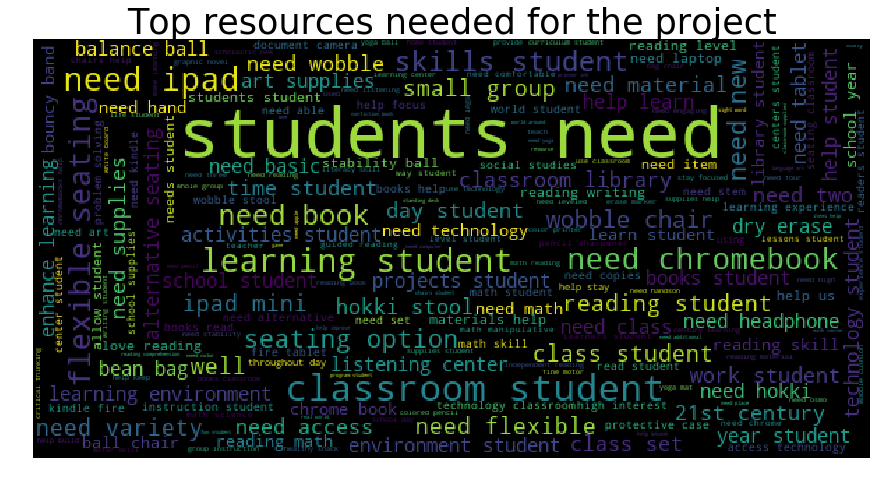

In [26]:
'''Title: A Very Extensive End to End Project: DonorsChoose
    Author: Lathwal
    Date: 2018
    Code version: 1.0
    Availability: https://www.kaggle.com/codename007/a-very-extensive-end-to-end-project-donorschoose/notebook
'''

temp_data = df_train.dropna(subset=['project_resource_summary'])
# converting into lowercase
temp_data['project_resource_summary'] = temp_data['project_resource_summary'].apply(lambda x: " ".join(x.lower() for x in x.split()))
temp_data['project_resource_summary'] = temp_data['project_resource_summary'].map(text_prepare)


from wordcloud import WordCloud # https://github.com/amueller/word_cloud

wordcloud = WordCloud(max_font_size=50, width=600, height=300).generate(' '.join(temp_data['project_resource_summary'].values))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.title("Top resources needed for the project", fontsize=35)
plt.axis("off")
plt.show() 

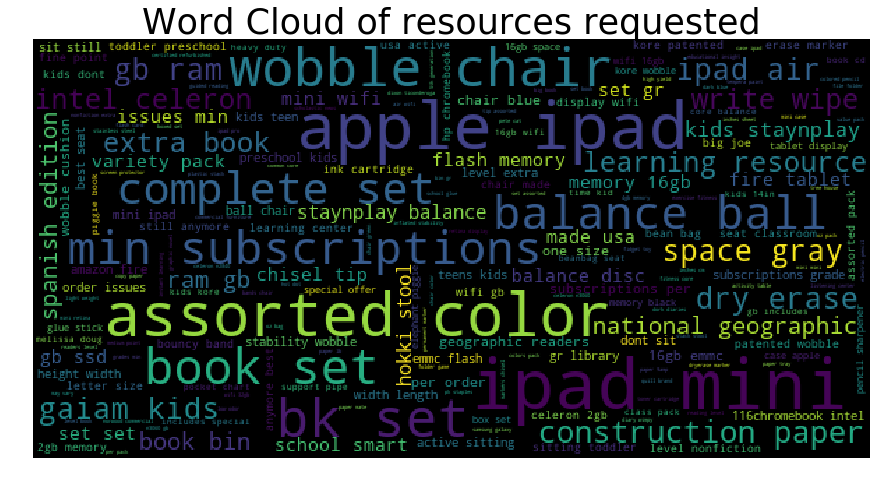

In [27]:
'''Title: A Very Extensive End to End Project: DonorsChoose
    Author: Lathwal
    Date: 2018
    Code version: 1.0
    Availability: https://www.kaggle.com/codename007/a-very-extensive-end-to-end-project-donorschoose/notebook
'''

temp_data = train_resource.dropna(subset=['description'])
# converting into lowercase
temp_data['description'] = temp_data['description'].apply(lambda x: " ".join(x.lower() for x in x.split()))
temp_data['description'] = temp_data['description'].map(text_prepare)


from wordcloud import WordCloud

wordcloud = WordCloud(max_font_size=50, width=600, height=300).generate(' '.join(temp_data['description'].values))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.title("Word Cloud of resources requested", fontsize=35)
plt.axis("off")
plt.show() 